In [47]:
import pandas as pd
import datetime as dt
from pandas.core.frame import DataFrame
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import watermark
from collections import namedtuple
from adjustText import adjust_text
from pathlib import Path
print(
    watermark.watermark(iversions=True, python=True,
                        machine=True, globals_=globals())
)

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.21.0

Compiler    : GCC 14.2.1 20240817
OS          : Linux
Release     : 6.10.7-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit

pandas    : 2.2.2
seaborn   : 0.13.2
watermark : 2.4.3
requests  : 2.31.0
numpy     : 1.26.4
matplotlib: 3.9.2



In [48]:
!wget -O data/alldata.csv https://salsa.debian.org/benchmarksgame-team/benchmarksgame/-/raw/master/public/data/alldata.csv

--2024-09-08 11:10:31--  https://salsa.debian.org/benchmarksgame-team/benchmarksgame/-/raw/master/public/data/alldata.csv
Resolving salsa.debian.org... 209.87.16.44, 2607:f8f0:614:1::1274:44
Connecting to salsa.debian.org|209.87.16.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748660 (731K) [text/plain]
Saving to: ‘data/alldata.csv’

data/alldata.csv    100%[===================>] 731.11K   810KB/s    in 0.9s    

2024-09-08 11:10:32 (810 KB/s) - ‘data/alldata.csv’ saved [748660/748660]



In [49]:
lang_dict = {
    "C": "C/C++",
    "C++": "C/C++",
    "Delphi/Object Pascal": "Delphi/Pascal",
    "MATLAB": "Matlab",
    "Cobol": "COBOL",
    # "VBA": "Visual Basic",
    "Powershell": "PowerShell",
    "VBScript": 'VBA/VBS',
    "VBA": "VBA/VBS",
    "ABAP": "Abap",
}

In [50]:
tiobe_url = "https://www.tiobe.com/tiobe-index/"


def get_tiobe_rank(url: str) -> DataFrame:
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        # Найти таблицу с индексом TIOBE по ее структуре или каким-то уникальным признакам
        # Это пример и может потребоваться адаптация
        table_class = "table table-striped table-top20"
        table = soup.find("table", {"class": table_class})
        rows = table.find_all("tr")

        ratings = []
        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 3:
                rank = int(cols[0].text.strip())
                lang = cols[4].text.strip()
                share = float(cols[5].text.replace("%", "").strip())
                trend = float(cols[6].text.replace("%", "").strip())
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

        table = soup.find("table", {"id": "otherPL"})
        rows = table.find_all("tr")

        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 2:
                rank = int(cols[0].text.strip())
                lang = cols[1].text.strip()
                share = float(cols[2].text.replace("%", "").strip())
                trend = None
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

    else:
        print("Не удалось получить данные с сайта TIOBE.")

    tiobe_rank = pd.DataFrame(ratings)
    tiobe_rank = tiobe_rank.replace(
        lang_dict).groupby("lang").sum().reset_index()
    return tiobe_rank


tiobe_rank = get_tiobe_rank(tiobe_url)
tiobe_rank

,lang,rank,share,trend
0,(Visual) FoxPro,29,0.63,0.00
1,Abap,38,0.34,0.00
2,Ada,26,0.71,0.00
3,Assembly language,21,0.99,0.00
4,Awk,44,0.20,0.00
5,C#,5,6.08,-1.22
6,C/C++,6,19.64,-2.29
7,COBOL,19,1.09,0.22
8,Classic Visual Basic,22,0.92,0.00
9,D,36,0.37,0.00


In [51]:
def get_pypl_rank(url: str) -> DataFrame:
    # URL индекса популярности PYPL

    # Отправляем HTTP запрос и получаем результат
    response = requests.get(url)
    response.raise_for_status()  # Вызовет исключение, если запрос не успешен

    start_word = "<!-- begin section All-->"
    end_word = "<!-- end section All-->"
    start_idx = response.text.find(start_word) + len(start_word)
    end_idx = response.text.find(end_word)
    # Парсим HTML с помощью BeautifulSoup
    soup = BeautifulSoup(
        f"<tr>{response.content[start_idx:end_idx]}", "html.parser")
    rows = soup.find_all("tr")
    # Извлекаем данные о языках программирования и их доле
    ratings = []
    for row in rows:
        columns = row.find_all("td")
        rank = columns[0].text.strip()
        lang = columns[2].text.strip()
        share = float(columns[3].text.replace("%", "").strip())
        trend = float(columns[4].text.replace("%", "").strip())
        ratings.append({"rank": rank, "lang": lang,
                       "share": share, "trend": trend})
    df = pd.DataFrame(ratings)
    df.replace(lang_dict, inplace=True)
    return df


pypl_url = "https://pypl.github.io/PYPL.html"
# Получаем и выводим рейтинг языков программирования
pypl_rank = get_pypl_rank(pypl_url)
pypl_rank

,rank,lang,share,trend
0,1,Python,29.66,1.6
1,2,Java,15.64,-0.2
2,3,JavaScript,8.30,-1.0
3,4,C#,6.64,-0.1
4,5,C/C++,6.46,-0.2
5,6,R,4.66,0.2
6,7,PHP,4.35,-0.5
7,8,TypeScript,2.96,-0.0
8,9,Swift,2.69,0.0
9,10,Rust,2.65,0.6


In [52]:
rank_all = pd.merge(
    tiobe_rank, pypl_rank, on="lang", how="outer", suffixes=("_tiobe", "_pypl")
)
rank_all['trend_norm'] = np.sqrt(rank_all.fillna(
    0)['trend_tiobe']**2+rank_all.fillna(0)['trend_pypl']**2)

rank_all['share_norm'] = np.sqrt(rank_all.fillna(
    0)['share_tiobe']**2+rank_all.fillna(0)['share_pypl']**2)
rank_all['norm_ratio'] = rank_all['trend_norm'] / rank_all['share_norm']
rank_all

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,share_norm,norm_ratio
0,(Visual) FoxPro,29.0,0.63,0.00,NaN,NaN,NaN,0.000000,0.630000,0.000000
1,Abap,38.0,0.34,0.00,21,0.59,-0.0,0.000000,0.680955,0.000000
2,Ada,26.0,0.71,0.00,18,0.96,-0.1,0.100000,1.194027,0.083750
3,Assembly language,21.0,0.99,0.00,NaN,NaN,NaN,0.000000,0.990000,0.000000
4,Awk,44.0,0.20,0.00,NaN,NaN,NaN,0.000000,0.200000,0.000000
5,C#,5.0,6.08,-1.22,4,6.64,-0.1,1.224091,9.003111,0.135963
6,C/C++,6.0,19.64,-2.29,5,6.46,-0.2,2.298717,20.675135,0.111183
7,COBOL,19.0,1.09,0.22,26,0.21,-0.0,0.220000,1.110045,0.198190
8,Classic Visual Basic,22.0,0.92,0.00,NaN,NaN,NaN,0.000000,0.920000,0.000000
9,D,36.0,0.37,0.00,NaN,NaN,NaN,0.000000,0.370000,0.000000


In [53]:
short_rank_all = rank_all.dropna(subset=["rank_tiobe", "rank_pypl"], how="any")
short_rank_all

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,share_norm,norm_ratio
1,Abap,38.0,0.34,0.00,21,0.59,-0.0,0.000000,0.680955,0.000000
2,Ada,26.0,0.71,0.00,18,0.96,-0.1,0.100000,1.194027,0.083750
5,C#,5.0,6.08,-1.22,4,6.64,-0.1,1.224091,9.003111,0.135963
6,C/C++,6.0,19.64,-2.29,5,6.46,-0.2,2.298717,20.675135,0.111183
7,COBOL,19.0,1.09,0.22,26,0.21,-0.0,0.220000,1.110045,0.198190
10,Dart,30.0,0.61,0.00,19,0.94,-0.0,0.000000,1.120580,0.000000
11,Delphi/Pascal,11.0,1.77,0.75,28,0.07,-0.1,0.756637,1.771384,0.427145
16,Go,8.0,2.35,1.16,12,2.08,0.2,1.177115,3.138296,0.375081
18,Haskell,28.0,0.64,0.00,29,0.06,-0.2,0.200000,0.642806,0.311136
19,Java,3.0,9.45,-0.04,2,15.64,-0.2,0.203961,18.273262,0.011162


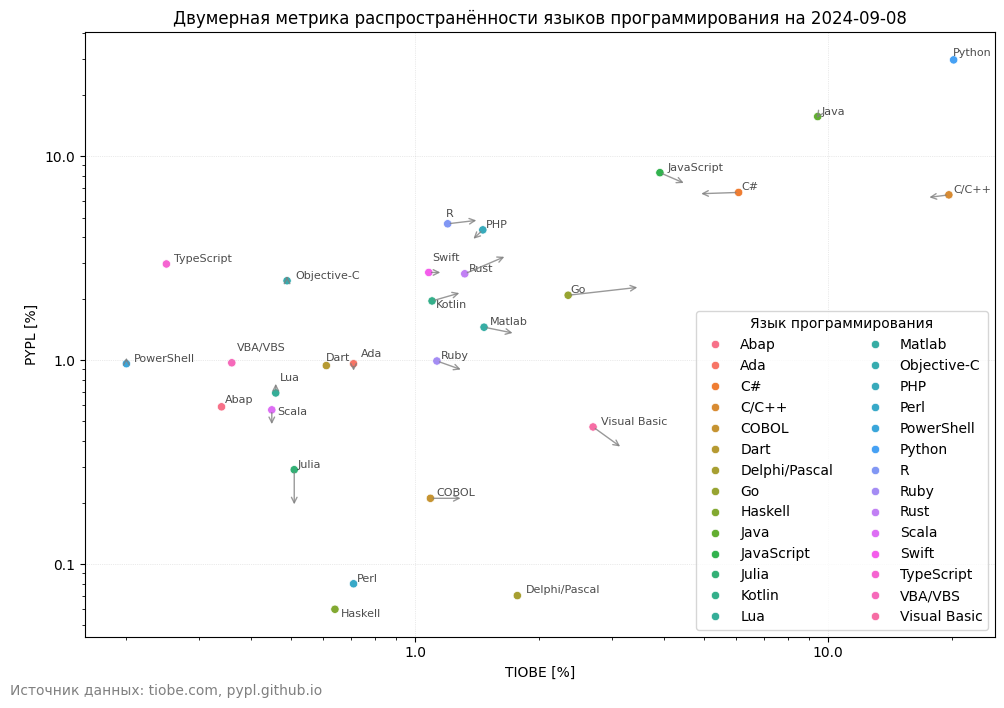

In [54]:
def norm(a, b) -> float:
    return (a**2 + b**2)**(1/2)


fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=short_rank_all, x="share_tiobe",
                     y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()}",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
texts = []
for x in short_rank_all.dropna().itertuples():
    texts.append(
        ax.text(x.share_tiobe, x.share_pypl, x.lang,
                fontsize=8, alpha=0.7)
    )
    if (x.trend_tiobe is not None) and (x.trend_pypl is not None):
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
adjust_text(texts)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
fig.tight_layout()
fig.text(0, 0, f"Источник данных: tiobe.com, pypl.github.io", color="grey")
fig.savefig(Path("output.png"), dpi=300)

## Расчёт с учётом оценки производительности

In [55]:
alias_bench = {
    'chapel': 'Chapel',
    'clang': 'C/C++',
    'csharpaot': 'C#',
    'csharpcore': 'C#',
    'dartexe': 'Dart',
    'dartjit': 'Dart',
    'erlang': 'Erland',
    'fpascal': 'Free Pascal',
    'fsharpcore': 'F#',
    'gcc': 'C/C++',
    'ghc': 'Haskell',
    'gnat': 'Ada',
    'go': 'Go',
    'gpp': 'C/C++',
    'graalvm': 'Graal',
    'icx': 'C/C++',
    'ifc': 'Fortran',
    'ifx': 'Fortran',
    'java': 'Java',
    'javaxint': 'Java',
    'julia': 'Julia',
    'lua': 'Lua',
    'micropython': 'Python',
    'mri': 'Ruby',
    'node': 'JavaScript',
    'ocaml': 'OCaml',
    'openj9': 'Java',
    'perl': 'Perl',
    'pharo': 'Smalltalk',
    'php': 'PHP',
    'python3': 'Python',
    'racket': 'Racket',
    'ruby': 'Ruby',
    'rust': 'Rust',
    'sbcl': 'Lisp',
    'swift': 'Swift',
    'toit': 'Toit',
    'vw': ''
}

In [56]:
bench_game = pd.read_csv(Path("data/alldata.csv"))
bench_game = bench_game[bench_game['status'] >= 0]
bench_game.drop(columns=['id', 'n'], inplace=True)
bench_game

,name,lang,size(B),cpu(s),mem(KB),status,load,elapsed(s),busy(s),started(s)
0,binarytrees,sbcl,595,0.035,22528,0,0% 3% 2% 0%,0.803,0.051,0.0
1,binarytrees,sbcl,595,0.095,97792,0,10% 100% 0% 0%,0.095,0.105,0.0
2,binarytrees,sbcl,595,9.629,643540,0,100% 0% 0% 0%,9.632,9.777,0.0
3,binarytrees,sbcl,595,9.636,643552,0,0% 0% 100% 0%,9.640,9.765,0.0
4,binarytrees,sbcl,595,9.606,643680,0,0% 100% 0% 0%,9.608,9.646,0.0
...,...,...,...,...,...,...,...,...,...,...
9691,toosimple,javaxint,206,3.312,36456,0,0% 1% 98% 0%,3.333,3.373,0.0
9692,toosimple,javaxint,206,323.603,36596,0,100% 0% 0% 0%,323.488,324.458,0.0
9693,toosimple,python3,150,0.181,19660,0,0% 23% 0% 1%,0.774,0.194,0.0
9694,toosimple,python3,150,11.219,19660,0,0% 0% 67% 32%,11.221,11.310,0.0


In [57]:
a = bench_game.groupby(['lang', 'name']).min(
    numeric_only=True).groupby('lang').median()
a['lang_name'] = a.index.map(alias_bench)
a

,size(B),cpu(s),mem(KB),status,elapsed(s),busy(s),started(s),lang_name
lang,,,,,,,,
chapel,526.0,0.0575,19680.0,0.0,0.2640,0.0555,0.0,Chapel
clang,654.0,0.0300,19700.0,0.0,0.0300,0.0270,0.0,C/C++
csharpaot,641.0,0.0640,19696.0,0.0,0.2060,0.0530,0.0,C#
csharpcore,641.0,0.1740,30948.0,0.0,0.3740,0.1810,0.0,C#
dartexe,511.5,0.0780,19808.0,0.0,0.0975,0.0850,0.0,Dart
dartjit,511.5,1.4555,158450.0,0.0,1.0685,1.4770,0.0,Dart
erlang,871.0,1.2460,55598.0,0.0,1.5695,1.2980,0.0,Erland
fpascal,959.0,0.0660,19672.0,0.0,0.0740,0.0700,0.0,Free Pascal
fsharpcore,725.5,0.2395,33156.0,0.0,0.3580,0.2385,0.0,F#


In [58]:
a = a.groupby('lang_name').median().sort_values(
    by="elapsed(s)", ascending=True)
a

,size(B),cpu(s),mem(KB),status,elapsed(s),busy(s),started(s)
lang_name,,,,,,,
C/C++,654.0,0.02800,19692.0,0.0,0.02950,0.03050,0.0
Rust,883.5,0.02250,19804.0,0.0,0.03850,0.02350,0.0
Go,658.5,0.06550,19808.0,0.0,0.04450,0.07200,0.0
Fortran,780.0,0.04800,19650.0,0.0,0.06050,0.04750,0.0
OCaml,473.0,0.05950,19676.0,0.0,0.07100,0.07650,0.0
Free Pascal,959.0,0.06600,19672.0,0.0,0.07400,0.07000,0.0
Lisp,905.5,0.11350,19680.0,0.0,0.20500,0.12950,0.0
Haskell,801.5,0.05250,19808.0,0.0,0.21600,0.05450,0.0
Ada,1259.0,0.06950,19808.0,0.0,0.23300,0.07550,0.0


In [59]:
a.sort_values(by="cpu(s)", ascending=True)

,size(B),cpu(s),mem(KB),status,elapsed(s),busy(s),started(s)
lang_name,,,,,,,
Rust,883.5,0.02250,19804.0,0.0,0.03850,0.02350,0.0
C/C++,654.0,0.02800,19692.0,0.0,0.02950,0.03050,0.0
Fortran,780.0,0.04800,19650.0,0.0,0.06050,0.04750,0.0
Haskell,801.5,0.05250,19808.0,0.0,0.21600,0.05450,0.0
Chapel,526.0,0.05750,19680.0,0.0,0.26400,0.05550,0.0
OCaml,473.0,0.05950,19676.0,0.0,0.07100,0.07650,0.0
Go,658.5,0.06550,19808.0,0.0,0.04450,0.07200,0.0
Free Pascal,959.0,0.06600,19672.0,0.0,0.07400,0.07000,0.0
Ada,1259.0,0.06950,19808.0,0.0,0.23300,0.07550,0.0


In [60]:
b = short_rank_all.join(a['elapsed(s)'], on="lang")
b['slower'] = b['elapsed(s)']/(b['elapsed(s)'].min())
for col in ['share_tiobe', 'share_pypl', 'trend_tiobe', 'trend_pypl']:
    b[col] = b[col]/b['slower']
b.dropna(inplace=True)
b

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,share_norm,norm_ratio,elapsed(s),slower
2,Ada,26.0,0.089893,0.000000,18,0.121545,-0.012661,0.100000,1.194027,0.083750,0.23300,7.898305
5,C#,5.0,0.618483,-0.124103,4,0.675448,-0.010172,1.224091,9.003111,0.135963,0.29000,9.830508
6,C/C++,6.0,19.640000,-2.290000,5,6.460000,-0.200000,2.298717,20.675135,0.111183,0.02950,1.000000
10,Dart,30.0,0.030866,0.000000,19,0.047564,-0.000000,0.000000,1.120580,0.000000,0.58300,19.762712
16,Go,8.0,1.557865,0.768989,12,1.378876,0.132584,1.177115,3.138296,0.375081,0.04450,1.508475
18,Haskell,28.0,0.087407,0.000000,29,0.008194,-0.027315,0.200000,0.642806,0.311136,0.21600,7.322034
19,Java,3.0,0.323780,-0.001370,2,0.535865,-0.006852,0.203961,18.273262,0.011162,0.86100,29.186441
20,JavaScript,6.0,0.266452,0.042143,3,0.564171,-0.067972,1.176605,9.179128,0.128183,0.43400,14.711864
21,Julia,31.0,0.018701,0.000000,24,0.010634,-0.003667,0.100000,0.586686,0.170449,0.80450,27.271186
26,Lua,33.0,0.015589,0.000000,20,0.023383,0.003389,0.100000,0.829277,0.120587,0.87050,29.508475


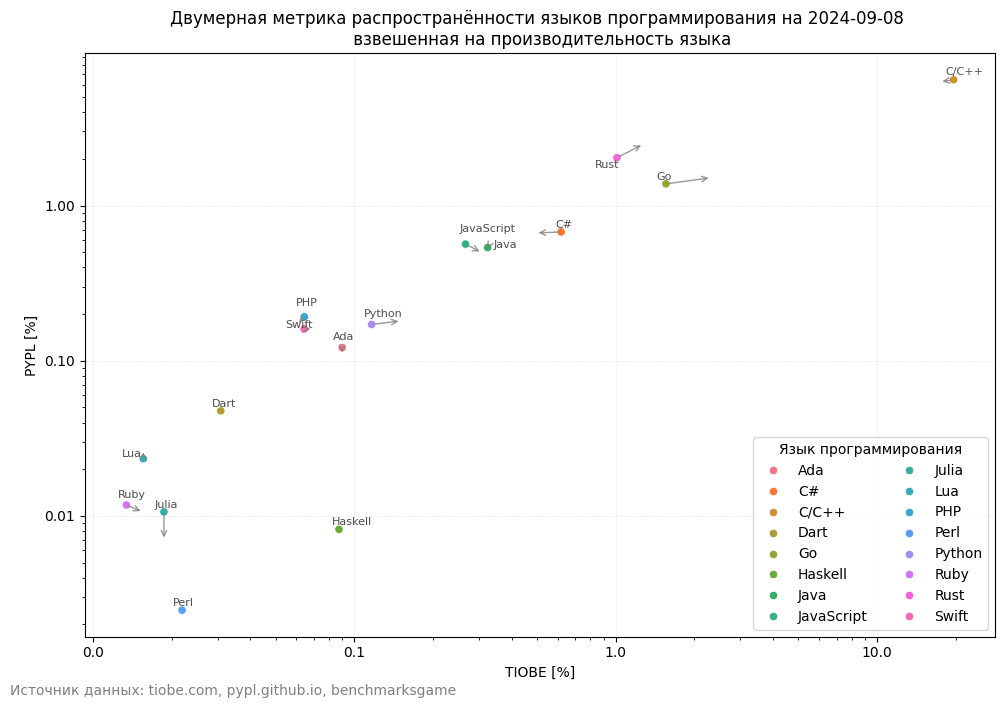

In [61]:
fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=b.dropna(), x="share_tiobe",
                     y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()} \n взвешенная на производительность языка",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
texts = []
obj = []
xx = []
yy = []
for x in b.dropna().itertuples():
    texts.append(ax.text(x.share_tiobe, x.share_pypl,
                 x.lang, fontsize=8, alpha=0.7, ha='center'))
    if (x.trend_tiobe is not None) and (x.trend_pypl is not None) and x.trend_norm > 0.0:
        xx.append(x.trend_tiobe + x.share_tiobe)
        yy.append(x.trend_pypl + x.share_pypl)
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
adjust_text(texts, x=xx, y=yy, ax=ax)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
fig.tight_layout()
fig.text(0, 0, f"Источник данных: tiobe.com, pypl.github.io, benchmarksgame", color='grey')
fig.savefig(Path("perf_rank.png"), dpi=300)